<a href="https://colab.research.google.com/github/allalena/unsupervised_learning_ml/blob/main/thinkful_unsupervised_learning_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import io
import seaborn as sns
from scipy import stats
import plotly.express as plotly

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

In [4]:
import requests

# Base URL for the GitHub API request
repo_api_url = 'https://api.github.com/repos/allalena/unsupervised_learning_ml/contents/'

# Make a GET request to the GitHub API
response = requests.get(repo_api_url)
if response.status_code == 200:
    repo_contents = response.json()
else:
    raise Exception(f"Failed to fetch repository contents: {response.status_code}")

# Filter out CSV files
csv_files = [file['name'] for file in repo_contents if file['name'].endswith('.csv')]

# Base URL for raw file contents
base_url = 'https://raw.githubusercontent.com/allalena/unsupervised_learning_ml/main/'

# Reading and concatenating the datasets in a loop
# For this study I will only choose few files because of the size of all files - It I use all the files, there are more than 6 million records
# I chose 6months 2019 csv files
dataframes = []
for file_name in csv_files:
    if file_name in ('2019_05.csv', '2019_06.csv'):

        file_url = base_url + file_name
        df = pd.read_csv(file_url)
        dataframes.append(df)

# Concatenate all dataframes
df = pd.concat(dataframes)


**<center>IMPORTANT</center>**<br>
**While the code provided in the Colab notebook includes the steps to concatenate multiple files into one complete dataset, I opted to work with only a small sample of this dataset in practice. The primary reason for this decision was to accommodate the computational limitations and time constraints associated with processing large datasets in the Colab environment. Working with a smaller sample allowed for more efficient training and experimentation, while still demonstrating the key concepts and methodologies of the analysis.**


In [5]:
df.head(3)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2019-05-01,3251,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2019-05-01 14:46:00,2019-05-01 14:45:10,0.00,departed,No Jersey Coast,NJ Transit
1,2019-05-01,3251,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2019-05-01 14:56:00,2019-05-01 14:56:21,0.35,departed,No Jersey Coast,NJ Transit
2,2019-05-01,3251,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2019-05-01 15:05:00,2019-05-01 15:05:24,0.40,departed,No Jersey Coast,NJ Transit


## Exploratory Data Analysis

In [6]:
df.shape

(489380, 13)

In [7]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
stop_sequence,435814.0,8.076058,5.090954,1.0,4.000000,7.00,11.0,26.0
from_id,488987.0,4211.652140,11778.405358,1.0,58.000000,105.00,136.0,43599.0
to_id,488987.0,4216.066415,11782.438916,1.0,58.000000,105.00,136.0,43599.0
delay_minutes,435814.0,4.192855,6.830404,0.0,1.066667,2.35,5.1,223.0


In [8]:
# columns data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489380 entries, 0 to 238758
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            489380 non-null  object 
 1   train_id        489380 non-null  object 
 2   stop_sequence   435814 non-null  float64
 3   from            489380 non-null  object 
 4   from_id         488987 non-null  float64
 5   to              489380 non-null  object 
 6   to_id           488987 non-null  float64
 7   scheduled_time  435814 non-null  object 
 8   actual_time     489380 non-null  object 
 9   delay_minutes   435814 non-null  float64
 10  status          489380 non-null  object 
 11  line            489380 non-null  object 
 12  type            489380 non-null  object 
dtypes: float64(4), object(9)
memory usage: 52.3+ MB


## Check for NULLs

In [9]:
df.isnull().sum()

date                  0
train_id              0
stop_sequence     53566
from                  0
from_id             393
to                    0
to_id               393
scheduled_time    53566
actual_time           0
delay_minutes     53566
status                0
line                  0
type                  0
dtype: int64

From the above we can see that there are a lots of nulls. Since the dataset is quite large, the nulls will be dropped and keep only the reported data.

In [10]:
#Drop the nulls
df.dropna(inplace=True)

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2019-05-01,3251,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2019-05-01 14:46:00,2019-05-01 14:45:10,0.000000,departed,No Jersey Coast,NJ Transit
1,2019-05-01,3251,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2019-05-01 14:56:00,2019-05-01 14:56:21,0.350000,departed,No Jersey Coast,NJ Transit
2,2019-05-01,3251,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2019-05-01 15:05:00,2019-05-01 15:05:24,0.400000,departed,No Jersey Coast,NJ Transit
3,2019-05-01,3251,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2019-05-01 15:10:00,2019-05-01 15:13:08,3.133333,departed,No Jersey Coast,NJ Transit
4,2019-05-01,3251,5.0,Newark Airport,37953.0,Rahway,127.0,2019-05-01 15:21:00,2019-05-01 15:23:07,2.116667,departed,No Jersey Coast,NJ Transit


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435424 entries, 0 to 435423
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            435424 non-null  object 
 1   train_id        435424 non-null  object 
 2   stop_sequence   435424 non-null  float64
 3   from            435424 non-null  object 
 4   from_id         435424 non-null  float64
 5   to              435424 non-null  object 
 6   to_id           435424 non-null  float64
 7   scheduled_time  435424 non-null  object 
 8   actual_time     435424 non-null  object 
 9   delay_minutes   435424 non-null  float64
 10  status          435424 non-null  object 
 11  line            435424 non-null  object 
 12  type            435424 non-null  object 
dtypes: float64(4), object(9)
memory usage: 43.2+ MB


In [14]:
df.shape

(435424, 13)

As we can see after dropping the nulls, we still have more tthan 400000 observations.<br> Next I will work on feature engineering and do more exploration analysis.

## Feature Engineerning

In [15]:
df.head(2)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2019-05-01,3251,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2019-05-01 14:46:00,2019-05-01 14:45:10,0.00,departed,No Jersey Coast,NJ Transit
1,2019-05-01,3251,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2019-05-01 14:56:00,2019-05-01 14:56:21,0.35,departed,No Jersey Coast,NJ Transit


In [16]:
# Get day of the week
df['date'] = pd.to_datetime(df['date'])

df['scheduled_time'] = pd.to_datetime(df['scheduled_time'])

df['day_of_week'] = df['date'].dt.dayofweek
df['scheduled_time_dwk'] = df['scheduled_time'].dt.dayofweek
df['scheduled_time_hour'] = df['scheduled_time'].dt.hour
df['scheduled_time_min'] = df['scheduled_time'].dt.minute

In [17]:
# Compute is rush_hour yes or no
# Function to check if a given datetime is in rush hour
def is_rush_hour(dt):
    # Rush hour is between 7-9 AM and 4-6 PM on weekdays
    if dt.weekday() < 5:  # 0-4 corresponds to Monday-Friday
        if (dt.hour >= 7 and dt.hour < 9) or (dt.hour >= 16 and dt.hour < 18):
            return True
    return False

# Apply the function to the datetime column
df['is_rush_hour'] = df['scheduled_time'].apply(is_rush_hour)


In [18]:
df.head(2)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,day_of_week,scheduled_time_dwk,scheduled_time_hour,scheduled_time_min,is_rush_hour
0,2019-05-01,3251,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2019-05-01 14:46:00,2019-05-01 14:45:10,0.00,departed,No Jersey Coast,NJ Transit,2,2,14,46,False
1,2019-05-01,3251,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2019-05-01 14:56:00,2019-05-01 14:56:21,0.35,departed,No Jersey Coast,NJ Transit,2,2,14,56,False


In [19]:
# Compute is_delayed column
df['is_delayed'] = df['delay_minutes'].apply(lambda x: 1 if x != 0 else 0)

In [20]:
df.head(2)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,day_of_week,scheduled_time_dwk,scheduled_time_hour,scheduled_time_min,is_rush_hour,is_delayed
0,2019-05-01,3251,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2019-05-01 14:46:00,2019-05-01 14:45:10,0.00,departed,No Jersey Coast,NJ Transit,2,2,14,46,False,0
1,2019-05-01,3251,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2019-05-01 14:56:00,2019-05-01 14:56:21,0.35,departed,No Jersey Coast,NJ Transit,2,2,14,56,False,1


In [21]:
# Label encode is_rush_hour
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the column to be label encoded
df['is_rush_hour'] = label_encoder.fit_transform(df['is_rush_hour'])

In [22]:
# Get the day of the week as its full name
df['scheduled_time_dwk_name'] = df['scheduled_time'].dt.strftime('%A')

In [23]:
# Cast from_id and to_id to int
df['from_id'] = df['from_id'].astype(int)
df['to_id'] = df['to_id'].astype(int)


In [24]:
# Apply one hot encoding
columns_to_encode = ['scheduled_time_dwk']
df_encoded = pd.get_dummies(df, columns = columns_to_encode)

In [20]:
df_encoded.head(2)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,...,is_rush_hour,is_delayed,scheduled_time_dwk_name,scheduled_time_dwk_0,scheduled_time_dwk_1,scheduled_time_dwk_2,scheduled_time_dwk_3,scheduled_time_dwk_4,scheduled_time_dwk_5,scheduled_time_dwk_6
0,2019-06-01,4773,1.0,Long Branch,74,Long Branch,74,2019-06-01 21:46:00,2019-06-01 21:45:18,0.000000,...,0,0,Saturday,0,0,0,0,0,1,0
1,2019-06-01,4773,2.0,Long Branch,74,Elberon,40,2019-06-01 21:50:00,2019-06-01 21:58:08,8.133333,...,0,1,Saturday,0,0,0,0,0,1,0


In [25]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435424 entries, 0 to 435423
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     435424 non-null  datetime64[ns]
 1   train_id                 435424 non-null  object        
 2   stop_sequence            435424 non-null  float64       
 3   from                     435424 non-null  object        
 4   from_id                  435424 non-null  int64         
 5   to                       435424 non-null  object        
 6   to_id                    435424 non-null  int64         
 7   scheduled_time           435424 non-null  datetime64[ns]
 8   actual_time              435424 non-null  object        
 9   delay_minutes            435424 non-null  float64       
 10  status                   435424 non-null  object        
 11  line                     435424 non-null  object        
 12  type            

## Exploratory Data Analysis

In [26]:
# Descriptive statistics
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
stop_sequence,435424.0,8.074394,5.088383,1.0,4.000000,7.00,11.0,26.0
from_id,435424.0,4434.011469,12047.862871,1.0,59.000000,104.00,136.0,43599.0
to_id,435424.0,4424.242118,12035.537389,1.0,59.000000,104.00,137.0,43599.0
delay_minutes,435424.0,4.190647,6.827358,0.0,1.066667,2.35,5.1,223.0
day_of_week,435424.0,2.715808,1.839622,0.0,1.000000,3.00,4.0,6.0
scheduled_time_hour,435424.0,13.204341,5.726011,0.0,8.000000,14.00,18.0,23.0
scheduled_time_min,435424.0,29.101418,17.430026,0.0,14.000000,29.00,44.0,59.0
is_rush_hour,435424.0,0.222592,0.415987,0.0,0.000000,0.00,0.0,1.0
is_delayed,435424.0,0.860240,0.346739,0.0,1.000000,1.00,1.0,1.0
scheduled_time_dwk_0,435424.0,0.145697,0.352803,0.0,0.000000,0.00,0.0,1.0


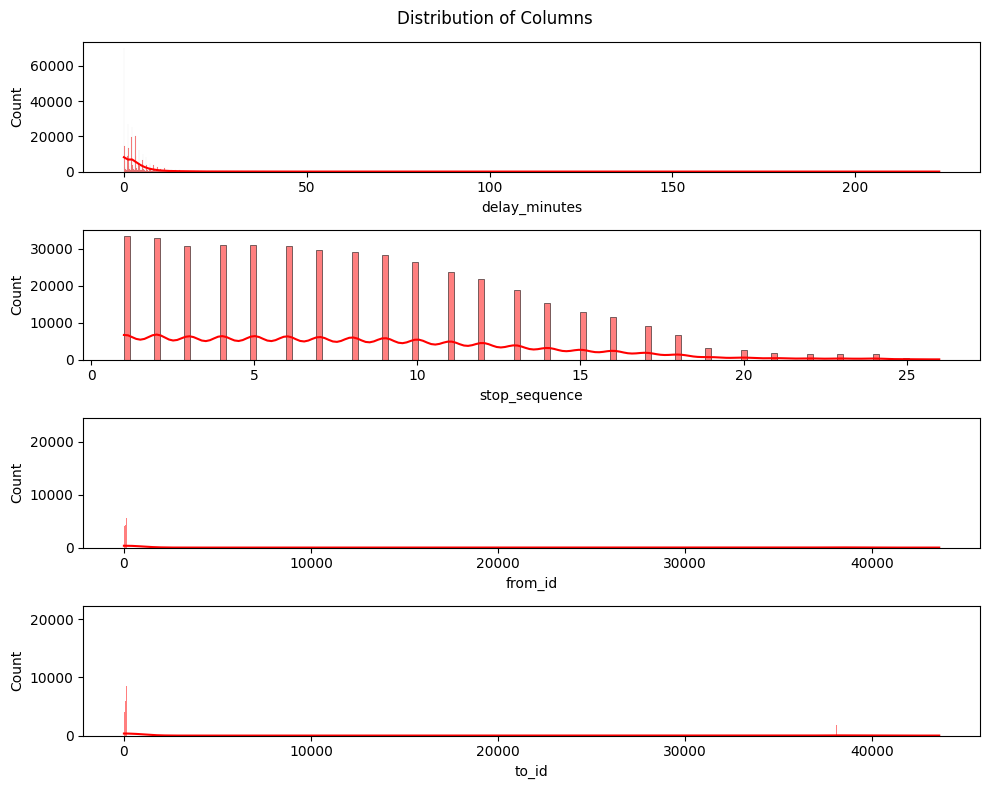

In [27]:
# Check distribution of the continous features
cols=['delay_minutes', 'stop_sequence', 'from_id', 'to_id']
fig, ax = plt.subplots(4, 1, figsize=(10, 8))
for i, col in enumerate(cols):
    sns.histplot(df_encoded[col], kde=True, ax=ax[i], color='red')
fig.suptitle('Distribution of Columns')
fig.tight_layout()
plt.show()

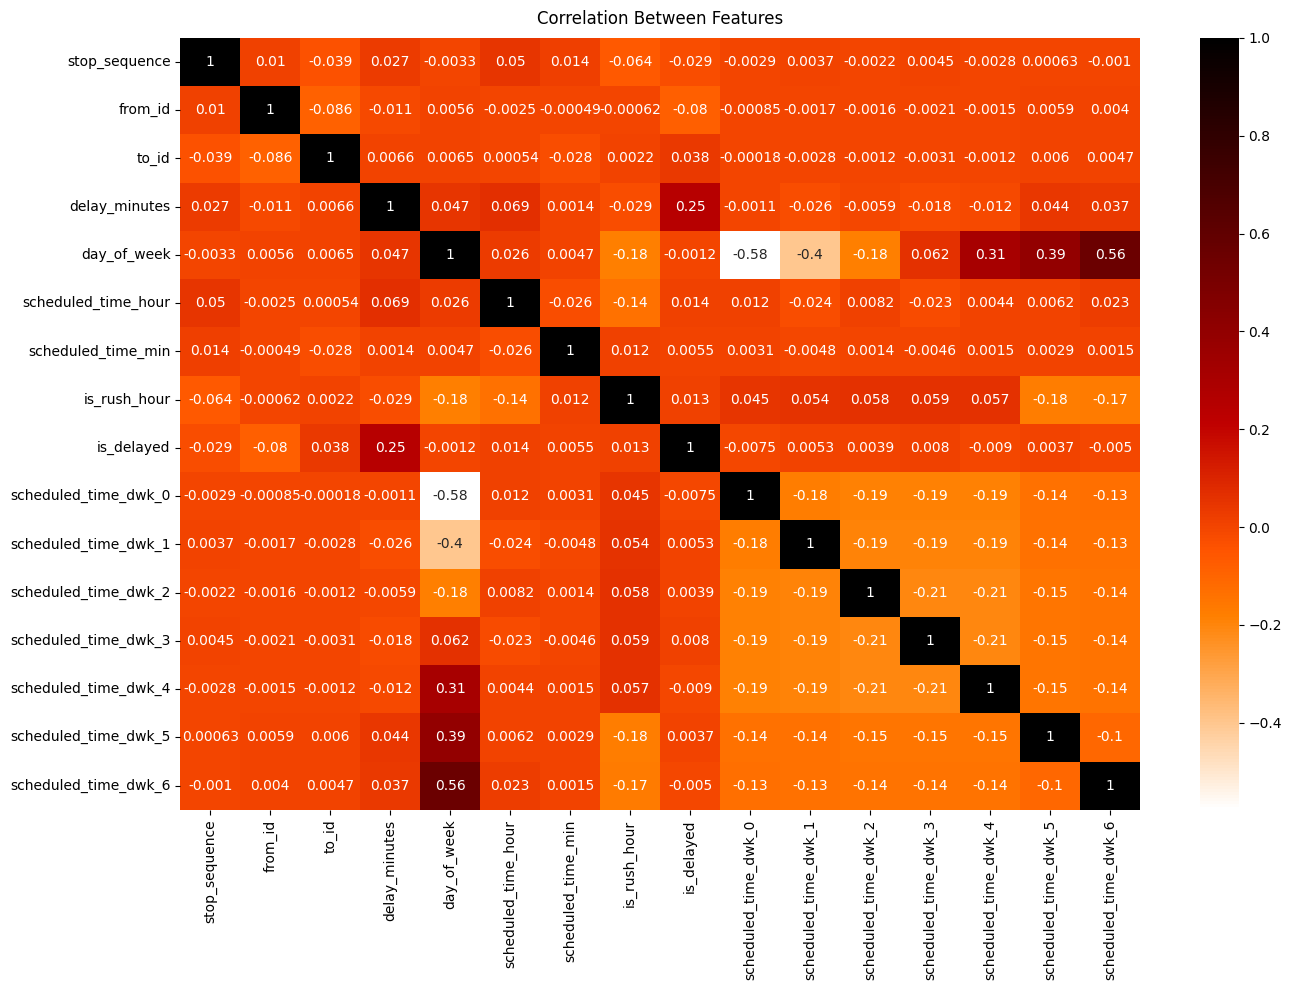

In [28]:
# Correlation between features
corr = df_encoded.corr(numeric_only=True)
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='gist_heat_r')
plt.title("Correlation Between Features", pad=10)
plt.tight_layout()
plt.show()

From looking at the correlation matrix, from_id, to_id, scheduled_time_hour and scheduled_time_min have low correlation and will not be used in the clustering models. The focus will be on: stop_sequence, delay_minutes, status, scheduled_time_dwk, is_rush_hour, is_delayed

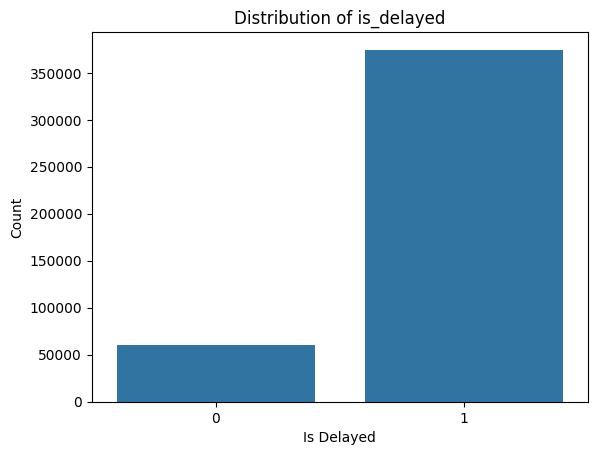

In [29]:
# Plotting the distribution of 'is_delayed'
sns.countplot(x='is_delayed', data=df_encoded)

# Setting plot title and labels
plt.title('Distribution of is_delayed')
plt.xlabel('Is Delayed')
plt.ylabel('Count')

# Show the plot
plt.show()

As we can see from the above count plot that there are more delays than on time

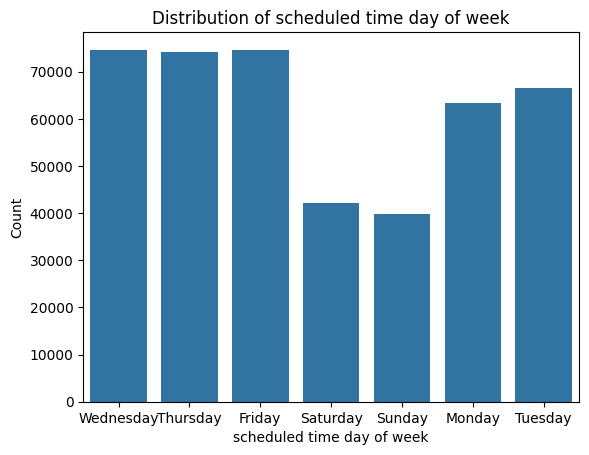

In [30]:
# Plotting the distribution of 'is_delayed'
sns.countplot(x='scheduled_time_dwk_name', data=df)

# Setting plot title and labels
plt.title('Distribution of scheduled time day of week')
plt.xlabel('scheduled time day of week')
plt.ylabel('Count')

# Show the plot
plt.show()

Friday has more scheduled trips. Saturday and Sunday have less scheduled trips.

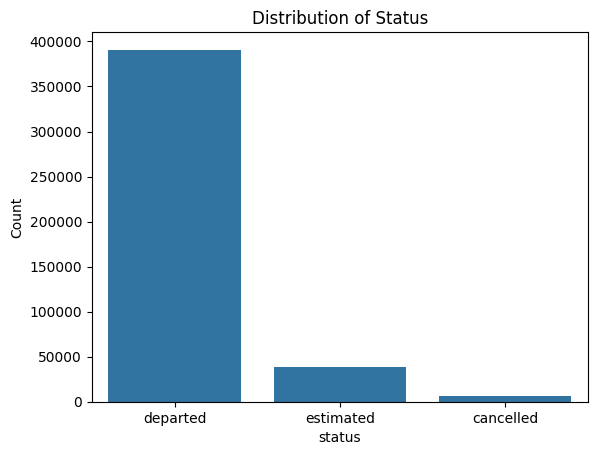

In [31]:
# Plotting the distribution of 'status'
sns.countplot(x='status', data=df)

# Setting plot title and labels
plt.title('Distribution of Status')
plt.xlabel('status')
plt.ylabel('Count')

# Show the plot
plt.show()

The overwhelming majority scheduled trips departed.

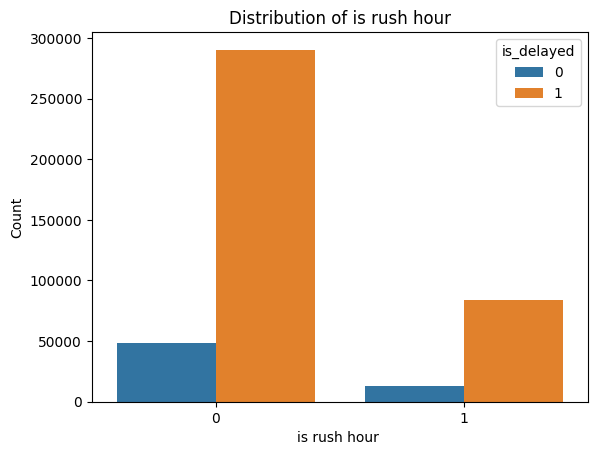

In [32]:
# Plotting the distribution of 'is rush hour '
sns.countplot(x='is_rush_hour', hue= 'is_delayed', data=df)

# Setting plot title and labels
plt.title('Distribution of is rush hour')
plt.xlabel('is rush hour ')
plt.ylabel('Count')

# Show the plot
plt.show()

Delays are present during normal time and rush hours. Normal hours have more delays then on time. Similarly, rush hour time have more delays then on time trips.

<ipython-input-33-13cb07f9d3d5>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['delay_minutes'])


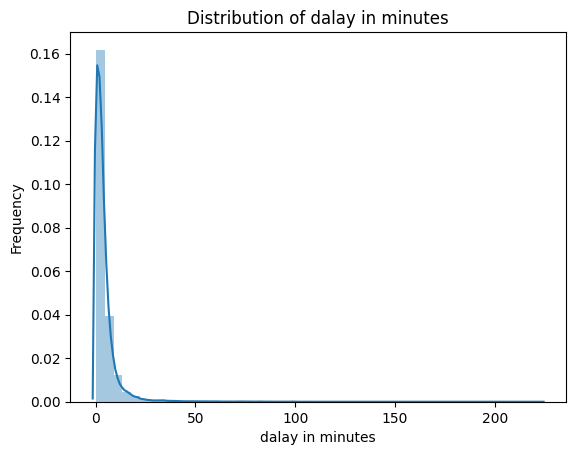

In [33]:
# Plotting the distribution of dalay in minutes
sns.distplot(df['delay_minutes'])

# Setting plot title and labels
plt.title('Distribution of dalay in minutes')
plt.xlabel('dalay in minutes')
plt.ylabel('Frequency')

# Show the plot
plt.show()

From the plot above, average dealy is around 5 minutes

## Data Preprocessing

In [34]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435424 entries, 0 to 435423
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     435424 non-null  datetime64[ns]
 1   train_id                 435424 non-null  object        
 2   stop_sequence            435424 non-null  float64       
 3   from                     435424 non-null  object        
 4   from_id                  435424 non-null  int64         
 5   to                       435424 non-null  object        
 6   to_id                    435424 non-null  int64         
 7   scheduled_time           435424 non-null  datetime64[ns]
 8   actual_time              435424 non-null  object        
 9   delay_minutes            435424 non-null  float64       
 10  status                   435424 non-null  object        
 11  line                     435424 non-null  object        
 12  type            

In [35]:
# Drop the columns with low correlation
columns_to_drop = ['date', 'train_id', 'from', 'from_id', 'to', 'to_id', 'status', 'scheduled_time', 'actual_time', 'line', 'type', 'day_of_week', 'scheduled_time_hour', 'scheduled_time_min', 'scheduled_time_dwk_name']
df_model = df_encoded.drop(columns_to_drop, axis=1)

In [36]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435424 entries, 0 to 435423
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   stop_sequence         435424 non-null  float64
 1   delay_minutes         435424 non-null  float64
 2   is_rush_hour          435424 non-null  int64  
 3   is_delayed            435424 non-null  int64  
 4   scheduled_time_dwk_0  435424 non-null  uint8  
 5   scheduled_time_dwk_1  435424 non-null  uint8  
 6   scheduled_time_dwk_2  435424 non-null  uint8  
 7   scheduled_time_dwk_3  435424 non-null  uint8  
 8   scheduled_time_dwk_4  435424 non-null  uint8  
 9   scheduled_time_dwk_5  435424 non-null  uint8  
 10  scheduled_time_dwk_6  435424 non-null  uint8  
dtypes: float64(2), int64(2), uint8(7)
memory usage: 16.2 MB


In [37]:
#Cast the scheduled time day of week to int
df_encoded['scheduled_time_dwk_0'] = df_encoded['scheduled_time_dwk_0'].astype(int)
df_encoded['scheduled_time_dwk_1'] = df_encoded['scheduled_time_dwk_1'].astype(int)
df_encoded['scheduled_time_dwk_2'] = df_encoded['scheduled_time_dwk_2'].astype(int)
df_encoded['scheduled_time_dwk_3'] = df_encoded['scheduled_time_dwk_3'].astype(int)
df_encoded['scheduled_time_dwk_4'] = df_encoded['scheduled_time_dwk_4'].astype(int)
df_encoded['scheduled_time_dwk_5'] = df_encoded['scheduled_time_dwk_5'].astype(int)
df_encoded['scheduled_time_dwk_6'] = df_encoded['scheduled_time_dwk_6'].astype(int)

# **PCA**

# Feature scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler() # Standardization
minmax = MinMaxScaler() # Normalization

#Scale the data
df_model['stop_sequence'] = minmax.fit_transform(df_model[['stop_sequence']])
df_model['delay_minutes'] = minmax.fit_transform(df_model[['delay_minutes']])


In [39]:
df_model.head(2)

,stop_sequence,delay_minutes,is_rush_hour,is_delayed,scheduled_time_dwk_0,scheduled_time_dwk_1,scheduled_time_dwk_2,scheduled_time_dwk_3,scheduled_time_dwk_4,scheduled_time_dwk_5,scheduled_time_dwk_6
0,0.00,0.00000,0,0,0,0,1,0,0,0,0
1,0.04,0.00157,0,1,0,0,1,0,0,0,0


In [34]:
pca = PCA()
df_model_pca = pd.DataFrame(pca.fit_transform(df_model))
pca.explained_variance_

array([1.89257688e-01, 1.58464536e-01, 1.57063009e-01, 1.56622761e-01,
       1.56162344e-01, 1.27603472e-01, 1.07638605e-01, 9.70316122e-02,
       4.10634045e-02, 4.40388920e-03, 6.10406381e-33])

The variance values of the selected features

### Plot the variance covered by each eigen value

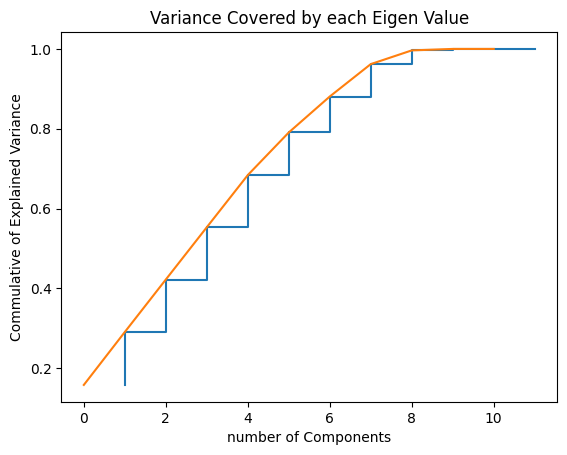

In [35]:
plt.step(list(range(1, 12)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of Components')
plt.ylabel('Commulative of Explained Variance')
plt.title('Variance Covered by each Eigen Value')
plt.show()

From the above, components with 70% to 90% or greater of the commulative variance are considered.

## PCA & K-Means

### The dataset is too large to efficiently fit a K-means clustering model, taking a representative sample of the whole dataset is a practical approach.

In [59]:
# Define the sample size. Here, we are taking a sample of 90,000 rows.
sample_size = 90000

# If the dataset is smaller than the desired sample size, use the full dataset
sample_size = min(sample_size, df_model.shape[0])

# Randomly select indices for the sample
sample_indices = np.random.choice(df_model.shape[0], sample_size, replace=False)

# Extract the sample
df_model_pca_sample = df_model.iloc[sample_indices]

In [60]:
df_model_pca_sample.reset_index(inplace=True, drop=True)

In [61]:
# Perform PCA to reduce data to 2 principal components for visualization
pca = PCA(n_components=2)
x_model_pca = pca.fit_transform(df_model_pca_sample)

### For k >= 4, We would like to answer the following questions:<br>
*  Which cluster contains the most train delay on Friday?
*  Which cluster contains the most train delays for the rush hour in the weekday?

## **K = 4**

<ipython-input-117-749d3fdcf8d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['label_4'] = clusters_4


Silhouette Score for 4 clusters: 0.72


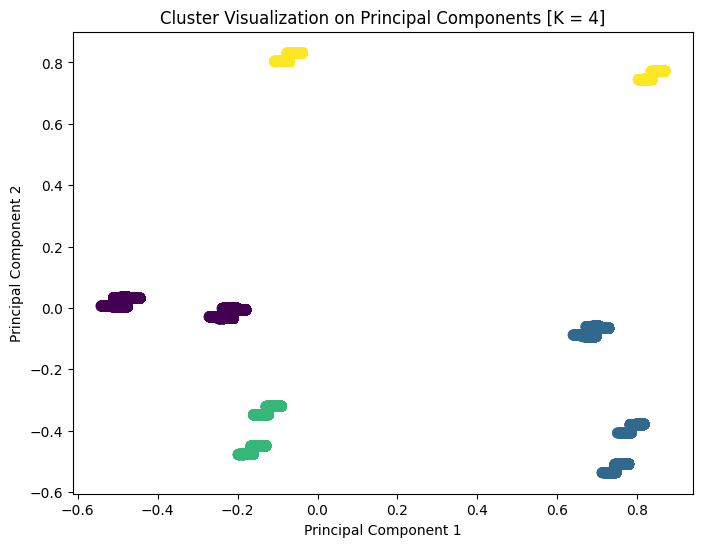

In [117]:
# Fit K-means using the principal components with k=4
kmeans = KMeans(n_clusters=4, max_iter=1000, n_init=10, random_state=42)
clusters_4 = kmeans.fit_predict(x_model_pca)

df_model_pca_sample['label_4'] = clusters_4

# Calculate silhouette score
silhouette_avg = silhouette_score(x_model_pca, clusters_4)
print(f'Silhouette Score for 4 clusters: {silhouette_avg:.2f}')

# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(x_model_pca[:, 0], x_model_pca[:, 1], c=clusters_4, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components [K = 4]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

K=4 clusters and obtained a silhouette score of 0.72. This indicates a fairly good cluster structure with well-defined clusters. However, to ensure we are capturing the most natural grouping in the data, we will explore clustering with a different number of clusters and compare the silhouette scores to determine the optimal number of clusters for our analysis.

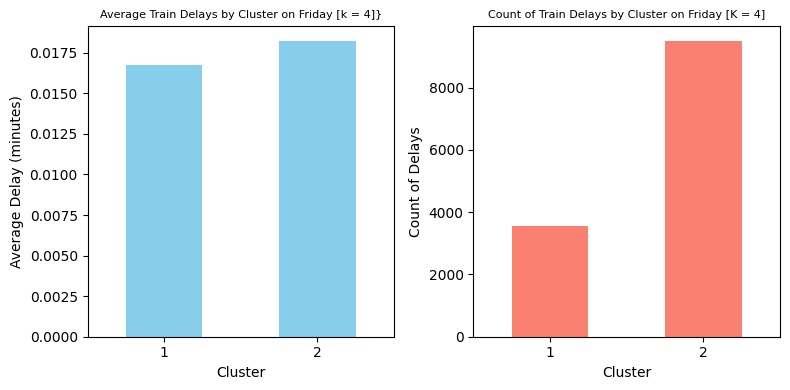

In [121]:
# 'scheduled_time_dwk_4' represents Friday
df_avg_friday_delays_k4 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_4')['delay_minutes'].mean()
df_cnt_friday_delays_k4 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_4')['is_delayed'].sum()

# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Average Train Delays on Friday
df_avg_friday_delays_k4.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays by Cluster on Friday [k = 4]}', fontsize=8)
axes[0].set_xticklabels(df_avg_friday_delays_k4.index, rotation=0)

# Count Train Delays on Friday
df_cnt_friday_delays_k4.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays by Cluster on Friday [K = 4]', fontsize=8)
axes[1].set_xticklabels(df_cnt_friday_delays_k4.index, rotation=0)

plt.tight_layout()
plt.show()

As we can see from the above, cluster 2 had more average Friday train delays and more total occurrences.

## **Which cluster contains the most train delays for the rush hour in the weekday?**

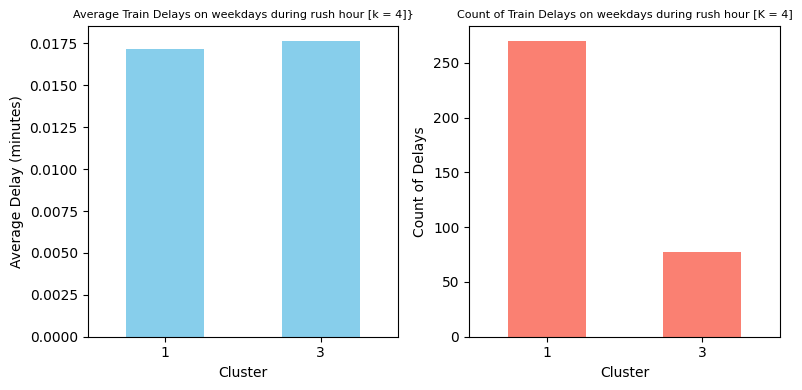

In [120]:

# Average of train delays during rush hours in weekdays
df_weekdays_k4 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_k4 = df_weekdays_k4[df_weekdays_k4['is_rush_hour'] == 1].groupby('label_4')['delay_minutes'].mean()

## Count of train delays during rush hours in weekdays
df_weekdays_cnt_k4 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_cnt_k4 = df_weekdays_cnt_k4[df_weekdays_cnt_k4['is_rush_hour'] == 1].groupby('label_4')['delay_minutes'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Average Train Delays on weekdays during rush hour
rush_hour_delays_k4.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays on weekdays during rush hour [k = 4]}', fontsize=8)
axes[0].set_xticklabels(rush_hour_delays_k4.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_cnt_k4.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays on weekdays during rush hour [K = 4]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_cnt_k4.index, rotation=0)

plt.tight_layout()
plt.show()

As we can see from the above, if we look at the average delays during rush hours in weekdays. Cluster 3 show a slight increase over cluster 1. However, if we consider the number of delays, cluster 1 clearly show cosiderable increase. So cluster 1 show more train delays during rush hour in weekdays.

## **K = 5 Clusters**

<ipython-input-73-37f809b14864>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['label_5'] = clusters_5


Silhouette Score for 5 clusters: 0.78


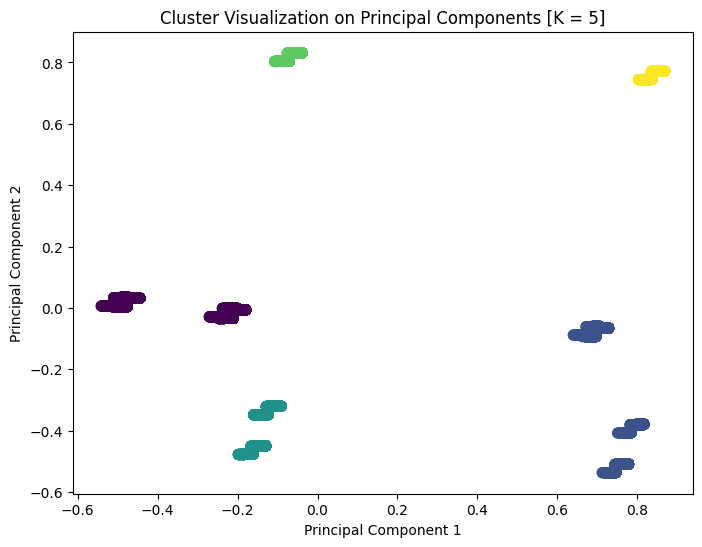

In [73]:
# Fit K-means using the principal components with k=5
kmeans = KMeans(n_clusters=5, max_iter=1000, n_init=10, random_state=42)
clusters_5 = kmeans.fit_predict(x_model_pca)

df_model_pca_sample['label_5'] = clusters_5

# Calculate silhouette score
silhouette_avg = silhouette_score(x_model_pca, clusters_5)
print(f'Silhouette Score for 5 clusters: {silhouette_avg:.2f}')

# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(x_model_pca[:, 0], x_model_pca[:, 1], c=clusters_5, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components [K = 5]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

K=5 clusters and obtained a silhouette score of 0.78. This indicates a fairly good cluster structure with well-defined clusters.

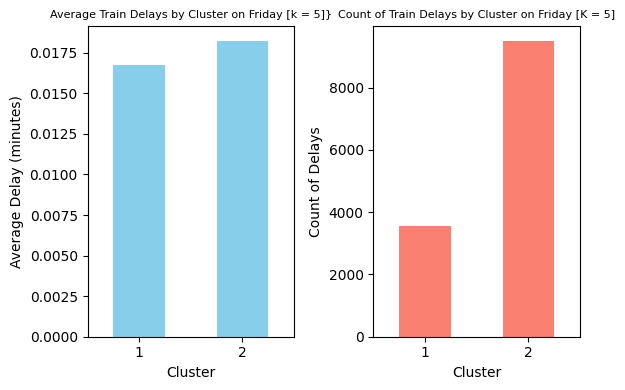

In [77]:
# 'scheduled_time_dwk_4' represents Friday
df_avg_friday_delays_k5 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_5')['delay_minutes'].mean()
df_cnt_friday_delays_k5 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_5')['is_delayed'].sum()

# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# Average Train Delays on Friday
df_avg_friday_delays_k5.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays by Cluster on Friday [k = 5]}', fontsize=8)
axes[0].set_xticklabels(df_avg_friday_delays_k5.index, rotation=0)

# Count Train Delays on Friday
df_cnt_friday_delays_k5.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays by Cluster on Friday [K = 5]', fontsize=8)
axes[1].set_xticklabels(df_cnt_friday_delays_k5.index, rotation=0)

plt.tight_layout()
plt.show()

As we can see from the above that cluster 2 presents more average dealys on fridays and also more delay occurrences on Fridays

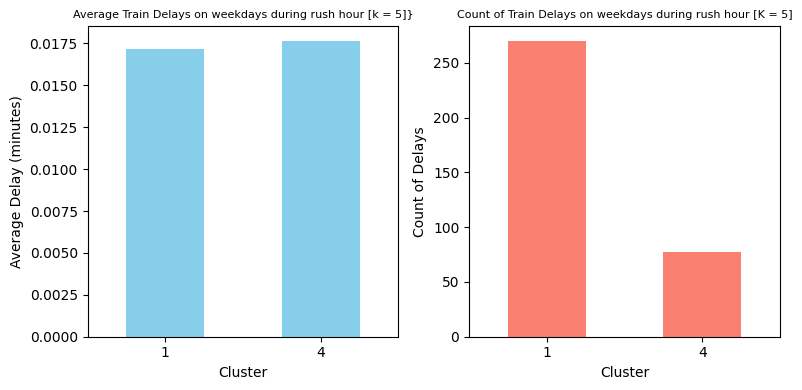

In [123]:
# Average of train delays during rush hours in weekdays
df_weekdays_k5 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_k5 = df_weekdays_k5[df_weekdays_k5['is_rush_hour'] == 1].groupby('label_5')['delay_minutes'].mean()

## Count of train delays during rush hours in weekdays
df_weekdays_cnt_k5 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_cnt_k5 = df_weekdays_cnt_k5[df_weekdays_cnt_k5['is_rush_hour'] == 1].groupby('label_5')['delay_minutes'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Average Train Delays on weekdays during rush hour
rush_hour_delays_k5.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays on weekdays during rush hour [k = 5]}', fontsize=8)
axes[0].set_xticklabels(rush_hour_delays_k5.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_cnt_k5.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays on weekdays during rush hour [K = 5]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_cnt_k5.index, rotation=0)

plt.tight_layout()
plt.show()

If we look at the above, we can say that cluster 4 has higher average delays during rush hours on weekdays. However has less occurrences. This could explain long delay occurences. Class 1 has higher dealy occurrences.

## **K = 6 Clusters**

<ipython-input-79-7a649042030d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['label_6'] = clusters_6


Silhouette Score for 6 clusters: 0.87


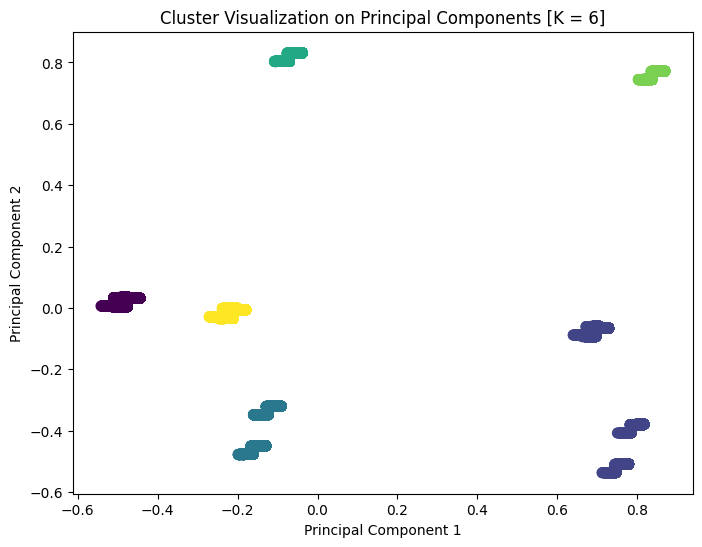

In [79]:
# Fit K-means using the principal components with k=6
kmeans = KMeans(n_clusters=6, max_iter=1000, n_init=10, random_state=42)
clusters_6 = kmeans.fit_predict(x_model_pca)

df_model_pca_sample['label_6'] = clusters_6

# Calculate silhouette score
silhouette_avg = silhouette_score(x_model_pca, clusters_6)
print(f'Silhouette Score for 6 clusters: {silhouette_avg:.2f}')

# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(x_model_pca[:, 0], x_model_pca[:, 1], c=clusters_6, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components [K = 6]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

K=6 clusters and obtained a silhouette score of 0.87. This indicates a fairly good cluster structure with well-defined clusters.

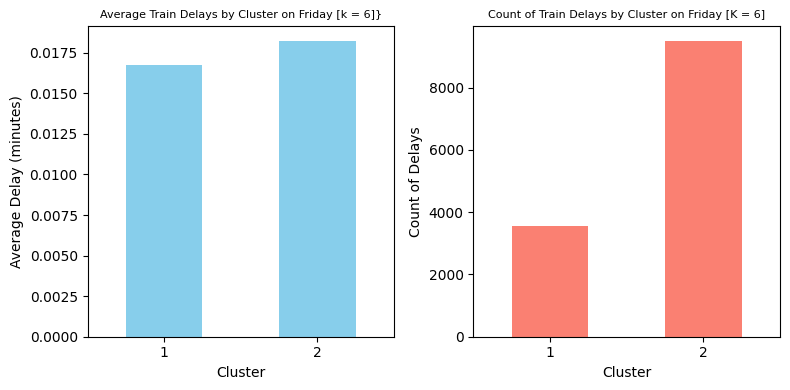

In [122]:
# 'scheduled_time_dwk_4' represents Friday
df_avg_friday_delays_k6 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_6')['delay_minutes'].mean()
df_cnt_friday_delays_k6 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_6')['is_delayed'].sum()

# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Average Train Delays on Friday
df_avg_friday_delays_k6.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays by Cluster on Friday [k = 6]}', fontsize=8)
axes[0].set_xticklabels(df_avg_friday_delays_k6.index, rotation=0)

# Count Train Delays on Friday
df_cnt_friday_delays_k6.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays by Cluster on Friday [K = 6]', fontsize=8)
axes[1].set_xticklabels(df_cnt_friday_delays_k6.index, rotation=0)

plt.tight_layout()
plt.show()

As we can see from the above, cluster 2 represent both higher average train delay and the number of delay occurrences.

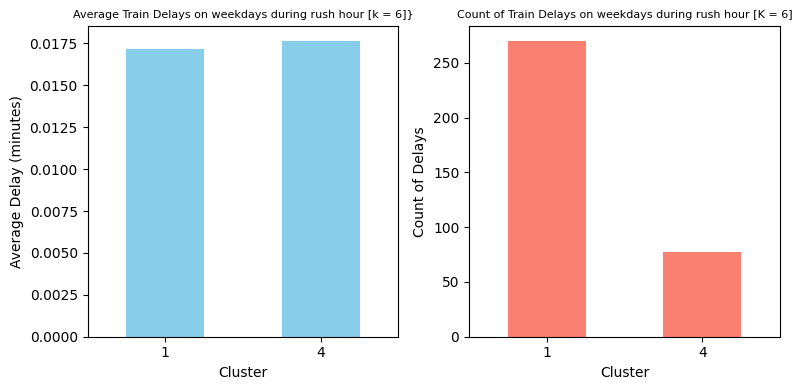

In [124]:
# Average of train delays during rush hours in weekdays
df_weekdays_k6 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_k6 = df_weekdays_k6[df_weekdays_k6['is_rush_hour'] == 1].groupby('label_6')['delay_minutes'].mean()

## Count of train delays during rush hours in weekdays
df_weekdays_cnt_k6 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_cnt_k6 = df_weekdays_cnt_k6[df_weekdays_cnt_k6['is_rush_hour'] == 1].groupby('label_6')['delay_minutes'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Average Train Delays on weekdays during rush hour
rush_hour_delays_k6.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays on weekdays during rush hour [k = 6]}', fontsize=8)
axes[0].set_xticklabels(rush_hour_delays_k6.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_cnt_k6.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays on weekdays during rush hour [K = 6]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_cnt_k6.index, rotation=0)

plt.tight_layout()
plt.show()

If we look at the above, we can say that cluster 4 has higher average delays during rush hours on weekdays. However has less occurrences. This could explain long delay occurences. Class 1 has higher dealy occurrences.

## **K = 7 Clusters**

<ipython-input-85-157221dda715>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['label_7'] = clusters_7


Silhouette Score for 7 clusters: 0.89


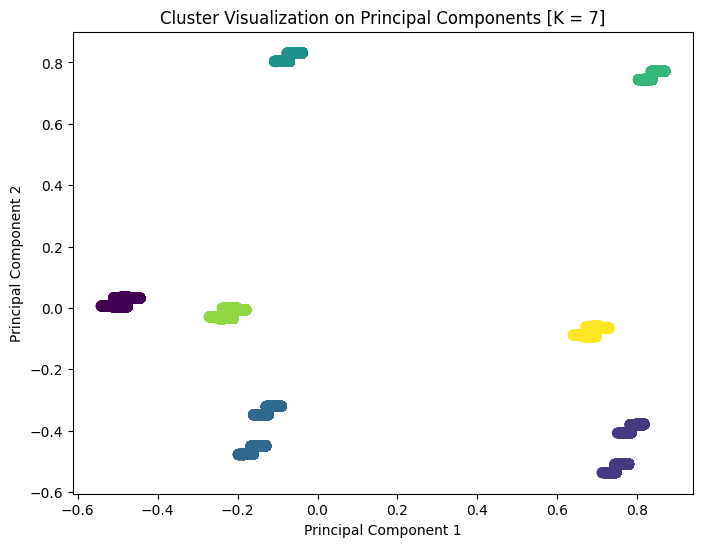

In [85]:
# Fit K-means using the principal components with k=7
kmeans = KMeans(n_clusters=7, max_iter=1000, n_init=10, random_state=42)
clusters_7 = kmeans.fit_predict(x_model_pca)

df_model_pca_sample['label_7'] = clusters_7

# Calculate silhouette score
silhouette_avg = silhouette_score(x_model_pca, clusters_7)
print(f'Silhouette Score for 7 clusters: {silhouette_avg:.2f}')

# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(x_model_pca[:, 0], x_model_pca[:, 1], c=clusters_7, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components [K = 7]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [128]:
# Count the occurrences of each cluster
clusters_7_counts = df_model_pca_sample['label_7'].value_counts()
# Print the counts
print(clusters_7_counts)

2    22175
5    19591
0    16985
3    11141
1     8452
6     7288
4     4368
Name: label_7, dtype: int64


K=7 clusters and obtained a silhouette score of 0.89. This model shows better silhouette score compared to the other clusters

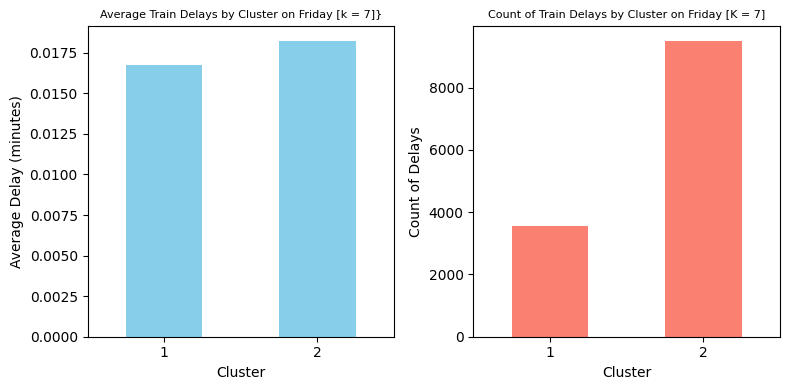

In [125]:
# 'scheduled_time_dwk_4' represents Friday
df_avg_friday_delays_k7 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_7')['delay_minutes'].mean()
df_cnt_friday_delays_k7 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('label_7')['is_delayed'].sum()

# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Average Train Delays on Friday
df_avg_friday_delays_k7.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays by Cluster on Friday [k = 7]}', fontsize=8)
axes[0].set_xticklabels(df_avg_friday_delays_k7.index, rotation=0)

# Count Train Delays on Friday
df_cnt_friday_delays_k7.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays by Cluster on Friday [K = 7]', fontsize=8)
axes[1].set_xticklabels(df_cnt_friday_delays_k7.index, rotation=0)

plt.tight_layout()
plt.show()

As we can see from the above, cluster 2 represent both higher average delay and number of train delay occurrences.

## Train delays during rush hours in weekdays

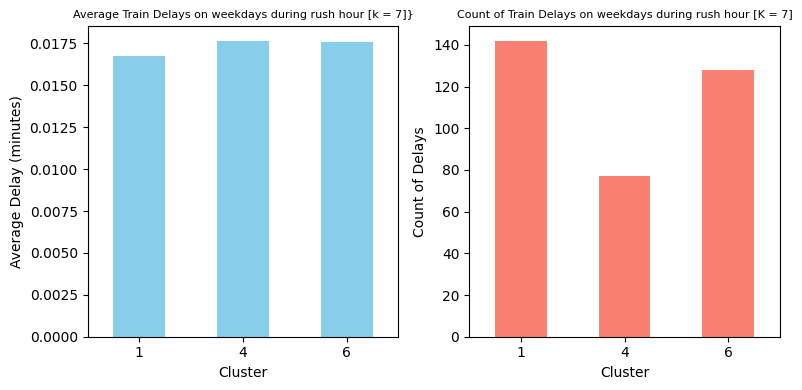

In [126]:
## Average of train delays during rush hours in weekdays
df_weekdays_k7 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_k7 = df_weekdays_k7[df_weekdays_k7['is_rush_hour'] == 1].groupby('label_7')['delay_minutes'].mean()

## Count of train delays during rush hours in weekdays
df_weekdays_cnt_k7 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_0'] + df_model_pca_sample['scheduled_time_dwk_1'] + \
                                  df_model_pca_sample['scheduled_time_dwk_2'] + df_model_pca_sample['scheduled_time_dwk_3'] + df_model_pca_sample['scheduled_time_dwk_4'] > 0]
rush_hour_delays_cnt_k7 = df_weekdays_cnt_k7[df_weekdays_cnt_k7['is_rush_hour'] == 1].groupby('label_7')['delay_minutes'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Average Train Delays on weekdays during rush hour
rush_hour_delays_k7.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Delay (minutes)')
axes[0].set_title('Average Train Delays on weekdays during rush hour [k = 7]}', fontsize=8)
axes[0].set_xticklabels(rush_hour_delays_k7.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_cnt_k7.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count of Delays')
axes[1].set_title('Count of Train Delays on weekdays during rush hour [K = 7]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_cnt_k7.index, rotation=0)

plt.tight_layout()
plt.show()

Cluster 6 shows higher average train delay on weekdays during rush hours. Cluster 1 shows higher number of occurrences of delay on weekdays during rush hour.

## **Clusters Evaluation** <br>
* K = 4 clusters    Silhouette_score: 0.72
* K = 5 clusters    Silhouette_score: 0.78
* K = 6 clusters    Silhouette_score: 0.87
* K = 7 clusters    Silhouette_score: 0.89 <br>

Overall, the last model where k =7 shows better silhouette score and also has more delays during week days.

## **Using T-sne and GMM to do the clustering** <br>
* Visualizations of clusters
* Evaluation of the silhouette scores)

## **T-SNE**

In [88]:
# Perform PCA to reduce data to 2 principal components for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_model = tsne.fit_transform(df_model_pca_sample)

## **GMM**

## **K = 4 Clusters**

In [96]:
from sklearn.mixture import GaussianMixture
# Defining the Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=4, max_iter=1000, random_state=42)
gmm_cluster_4 = gmm.fit_predict(tsne_model)

# Add cluster labels to the original DataFrame
df_model_pca_sample['gmm_label_4'] = gmm_cluster_4


<ipython-input-96-0e78a5f1f207>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['gmm_label_4'] = gmm_cluster_4


In [97]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tsne_model, gmm_cluster_4)
print(f'Silhouette Score t-SNE & GMM [k=4]: {silhouette_avg}')

Silhouette Score t-SNE & GMM [k=4]: 0.3382560908794403


The above GMM model shows a silhouette score of 0.33 which is on the lower side. However, to ensure we are capturing the most natural grouping in the data, we will explore clustering with a different number of clusters and compare the silhouette scores to determine the optimal number of clusters for our analysis.

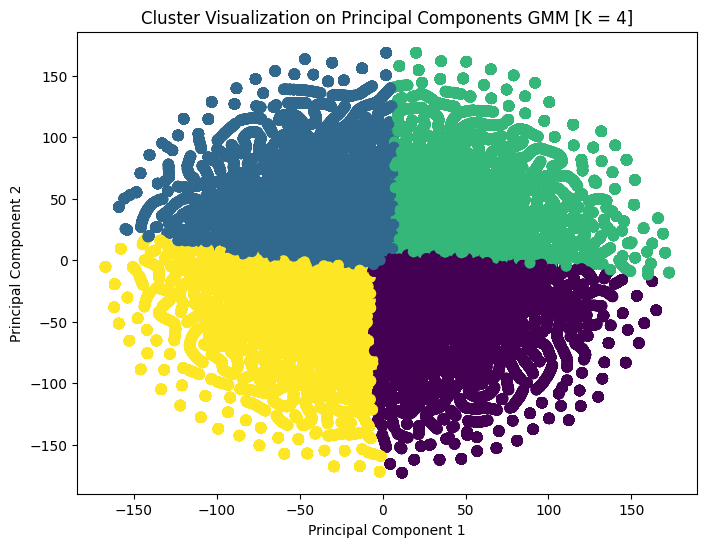

In [98]:
# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], c=gmm_cluster_4, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components GMM [K = 4]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

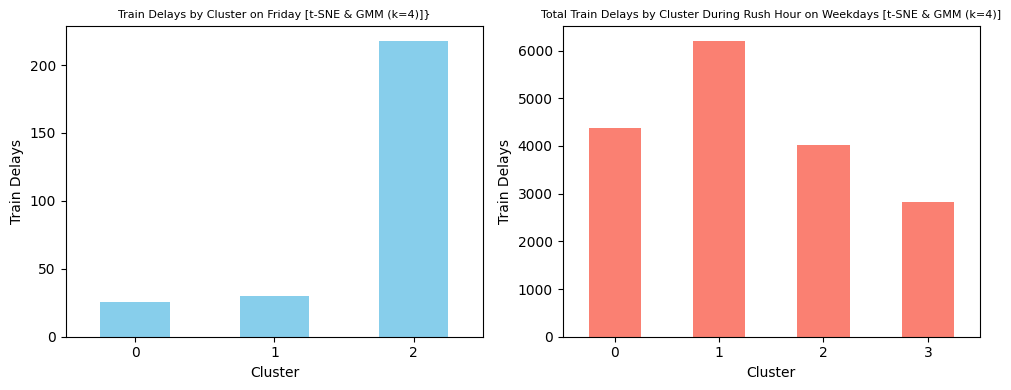

In [100]:
# a. Most Train Delay on Friday
friday_delays_gmm_4 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('gmm_label_4')['delay_minutes'].sum()

# b. Most Train Delays During Rush Hour on Weekdays
weekday_rush_hour_gmm_4 = df_model_pca_sample[(df_model_pca_sample['is_rush_hour'] == 1) &
                       (df_model_pca_sample[['scheduled_time_dwk_0', 'scheduled_time_dwk_1', 'scheduled_time_dwk_2',
                           'scheduled_time_dwk_3', 'scheduled_time_dwk_4']].sum(axis=1) > 0)]
rush_hour_delays_gmm_4 = weekday_rush_hour_gmm_4.groupby('gmm_label_4')['is_delayed'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Count of Train Delays on Fridays
friday_delays_gmm_4.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Train Delays')
axes[0].set_title('Train Delays by Cluster on Friday [t-SNE & GMM (k=4)]}', fontsize=8)
axes[0].set_xticklabels(friday_delays_gmm_4.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_gmm_4.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Train Delays')
axes[1].set_title('Total Train Delays by Cluster During Rush Hour on Weekdays [t-SNE & GMM (k=4)]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_gmm_4.index, rotation=0)

plt.tight_layout()
plt.show()

Clearly Cluster 2 has more delays then the other clusters. Cluster 1 has more train delays on weekdays during rush hours.

## **K = 5 Clusters**

In [103]:
# Defining the Gaussian Mixture Model clustering
gmm_5 = GaussianMixture(n_components=5, max_iter=1000, random_state=42)
gmm_cluster_5 = gmm_5.fit_predict(tsne_model)

# Add cluster labels to the original DataFrame
df_model_pca_sample['gmm_label_5'] = gmm_cluster_5

<ipython-input-103-893f911b2370>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['gmm_label_5'] = gmm_cluster_5


In [104]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tsne_model, gmm_cluster_5)
print(f'Silhouette Score t-SNE & GMM [k=5]: {silhouette_avg}')

Silhouette Score t-SNE & GMM [k=5]: 0.3210732340812683


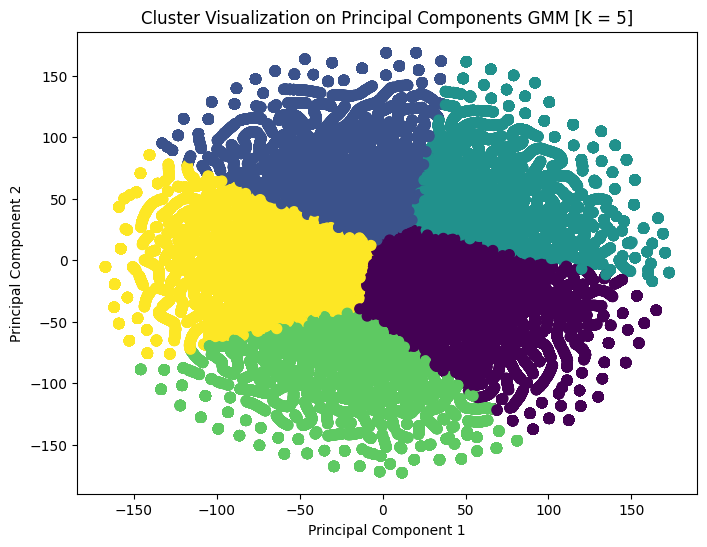

In [105]:
# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], c=gmm_cluster_5, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components GMM [K = 5]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

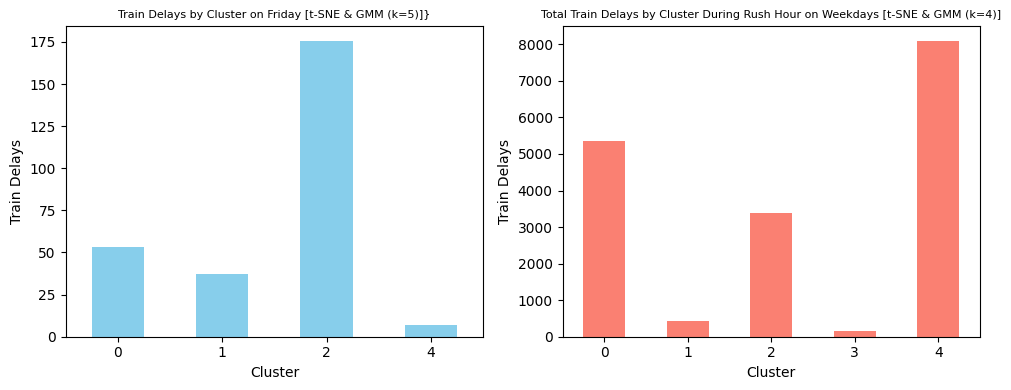

In [106]:
# a. Most Train Delay on Friday
friday_delays_gmm_5 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('gmm_label_5')['delay_minutes'].sum()

# b. Most Train Delays During Rush Hour on Weekdays
weekday_rush_hour_gmm_5 = df_model_pca_sample[(df_model_pca_sample['is_rush_hour'] == 1) &
                       (df_model_pca_sample[['scheduled_time_dwk_0', 'scheduled_time_dwk_1', 'scheduled_time_dwk_2',
                           'scheduled_time_dwk_3', 'scheduled_time_dwk_4']].sum(axis=1) > 0)]
rush_hour_delays_gmm_5 = weekday_rush_hour_gmm_5.groupby('gmm_label_5')['is_delayed'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Count of Train Delays on Fridays
friday_delays_gmm_5.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Train Delays')
axes[0].set_title('Train Delays by Cluster on Friday [t-SNE & GMM (k=5)]}', fontsize=8)
axes[0].set_xticklabels(friday_delays_gmm_5.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_gmm_5.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Train Delays')
axes[1].set_title('Total Train Delays by Cluster During Rush Hour on Weekdays [t-SNE & GMM (k=4)]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_gmm_5.index, rotation=0)

plt.tight_layout()
plt.show()

## **K= 6 Clusters**

In [108]:
# Defining the Gaussian Mixture Model clustering
gmm_6 = GaussianMixture(n_components=6, max_iter=1000, random_state=42)
gmm_cluster_6 = gmm_6.fit_predict(tsne_model)

# Add cluster labels to the original DataFrame
df_model_pca_sample['gmm_label_6'] = gmm_cluster_6

<ipython-input-108-0e31970547b6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['gmm_label_6'] = gmm_cluster_6


In [109]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tsne_model, gmm_cluster_6)
print(f'Silhouette Score t-SNE & GMM [k=6]: {silhouette_avg}')

Silhouette Score t-SNE & GMM [k=6]: 0.3493630290031433


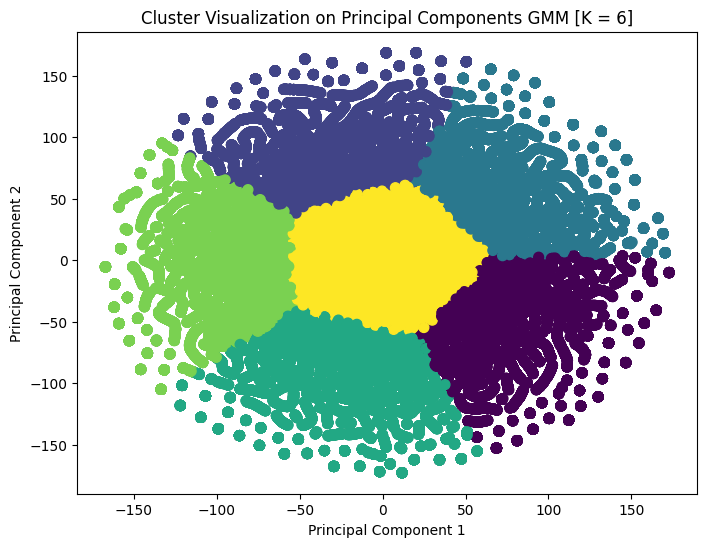

In [110]:
# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], c=gmm_cluster_6, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components GMM [K = 6]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

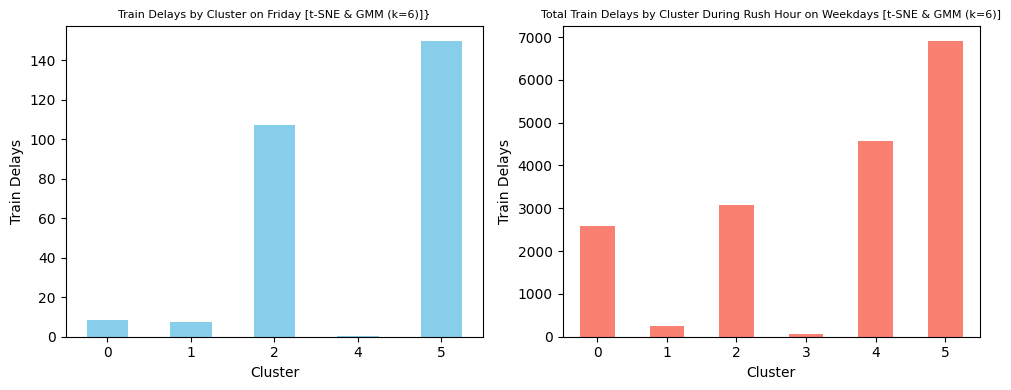

In [111]:
# a. Most Train Delay on Friday
friday_delays_gmm_6 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('gmm_label_6')['delay_minutes'].sum()

# b. Most Train Delays During Rush Hour on Weekdays
weekday_rush_hour_gmm_6 = df_model_pca_sample[(df_model_pca_sample['is_rush_hour'] == 1) &
                       (df_model_pca_sample[['scheduled_time_dwk_0', 'scheduled_time_dwk_1', 'scheduled_time_dwk_2',
                           'scheduled_time_dwk_3', 'scheduled_time_dwk_4']].sum(axis=1) > 0)]
rush_hour_delays_gmm_6 = weekday_rush_hour_gmm_6.groupby('gmm_label_6')['is_delayed'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Count of Train Delays on Fridays
friday_delays_gmm_6.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Train Delays')
axes[0].set_title('Train Delays by Cluster on Friday [t-SNE & GMM (k=6)]}', fontsize=8)
axes[0].set_xticklabels(friday_delays_gmm_6.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_gmm_6.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Train Delays')
axes[1].set_title('Total Train Delays by Cluster During Rush Hour on Weekdays [t-SNE & GMM (k=6)]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_gmm_6.index, rotation=0)

plt.tight_layout()
plt.show()

## **K = 7 Clusters**

In [112]:
# Defining the Gaussian Mixture Model clustering
gmm_7 = GaussianMixture(n_components=7, max_iter=1000, random_state=42)
gmm_cluster_7 = gmm_7.fit_predict(tsne_model)

# Add cluster labels to the original DataFrame
df_model_pca_sample['gmm_label_7'] = gmm_cluster_7

<ipython-input-112-995c5d3abfcf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_pca_sample['gmm_label_7'] = gmm_cluster_7


In [113]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tsne_model, gmm_cluster_7)
print(f'Silhouette Score t-SNE & GMM [k=7]: {silhouette_avg}')

Silhouette Score t-SNE & GMM [k=7]: 0.34360602498054504


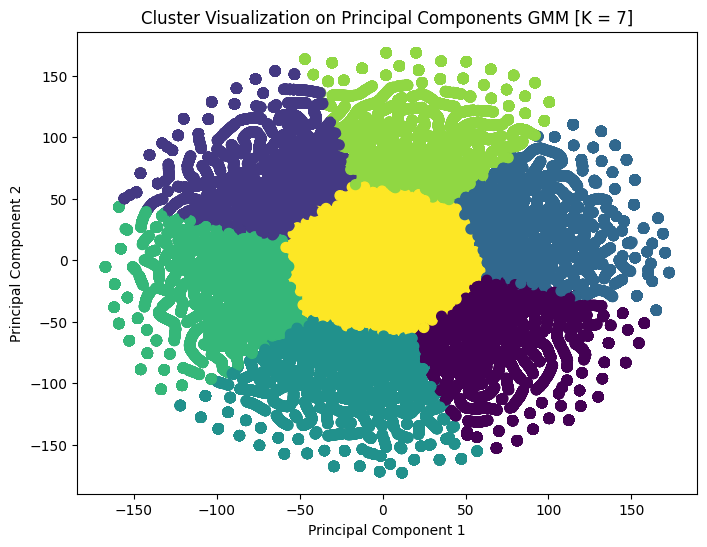

In [114]:
# Visualize the results on the principal components
plt.figure(figsize=(8, 6))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], c=gmm_cluster_7, s=50, cmap='viridis')
plt.title('Cluster Visualization on Principal Components GMM [K = 7]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

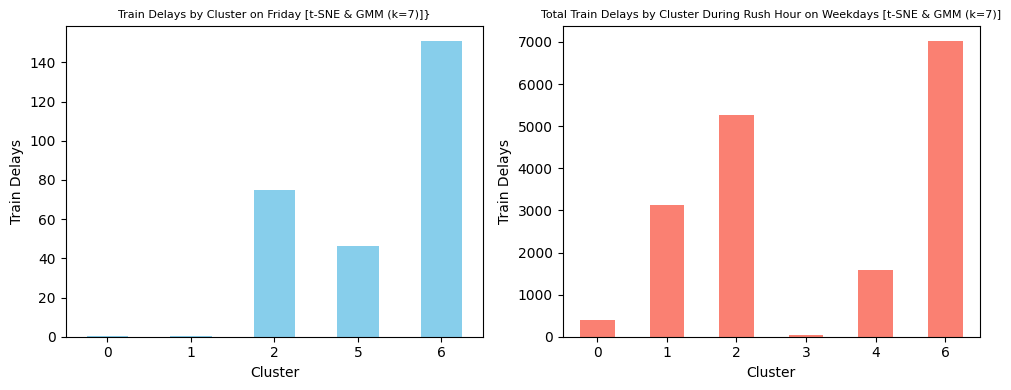

In [115]:
# a. Most Train Delay on Friday
friday_delays_gmm_7 = df_model_pca_sample[df_model_pca_sample['scheduled_time_dwk_4'] == 1].groupby('gmm_label_7')['delay_minutes'].sum()

# b. Most Train Delays During Rush Hour on Weekdays
weekday_rush_hour_gmm_7 = df_model_pca_sample[(df_model_pca_sample['is_rush_hour'] == 1) &
                       (df_model_pca_sample[['scheduled_time_dwk_0', 'scheduled_time_dwk_1', 'scheduled_time_dwk_2',
                           'scheduled_time_dwk_3', 'scheduled_time_dwk_4']].sum(axis=1) > 0)]
rush_hour_delays_gmm_7 = weekday_rush_hour_gmm_7.groupby('gmm_label_7')['is_delayed'].sum()


# Plotting side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Count of Train Delays on Fridays
friday_delays_gmm_7.plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Train Delays')
axes[0].set_title('Train Delays by Cluster on Friday [t-SNE & GMM (k=7)]}', fontsize=8)
axes[0].set_xticklabels(friday_delays_gmm_7.index, rotation=0)

# Count Train Delays on weekdays during rush hour
rush_hour_delays_gmm_7.plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Train Delays')
axes[1].set_title('Total Train Delays by Cluster During Rush Hour on Weekdays [t-SNE & GMM (k=7)]', fontsize=8)
axes[1].set_xticklabels(rush_hour_delays_gmm_7.index, rotation=0)

plt.tight_layout()
plt.show()

## **Results**

## **Clusters Evaluation** <br>
* K = 4 clusters    Silhouette_score: 0.33
* K = 5 clusters    Silhouette_score: 0.32
* K = 6 clusters    Silhouette_score: 0.34
* K = 7 clusters    Silhouette_score: 0.34 <br>

Overall, the last model where k = 6 and 7 shows better silhouette score. However, model k = 5 cluster is better as it showed more delays then the other models.

## **Results**<br>
Based on the silhouette score, PCA Reduction appears to be more effective than t-SNE. However, t-SNE had an increased number of clusters than PCA. This could be because t-SNE is particularly effective at preserving local structures and relationships within high-dimensional data. It excels at capturing the similarity between closely related data points, which makes it excellent for visualizing clusters in the data. Also, t-SNE is a non-linear technique, meaning it can capture complex patterns that linear methods like PCA might miss.

**Train Delay on Friday:** <br>
Based on the analysis, PCA and K-Means with k=7 showed a better silhouette score. If we consider silhouette score as the only metric to evaluate the clusters, PCA and K-means out performed t-SNE and GMM.

**Train Delay on weekdays during rush hour:**<br>
Similarly based on the analysis, PCA and K-Means with k= 6 and 7 showed a better silhouette score. If we consider silhouette score as the only metric to evaluate the clusters, PCA and K-means out performed t-SNE and GMM.

## **Conclusion**<br>
When focusing on identifying a greater number of clusters, both GMM and t-SNE have demonstrated the capability to reveal more clusters. Although the silhouette scores might not be exceptionally high, the increased number of clusters is noticeable, particularly with GMM. This is partly because t-SNE is highly effective at maintaining local structures and relationships within high-dimensional data. It excels in detecting similarities among closely related data points, thereby making it ideal for visualizing distinct clusters. Additionally, as a non-linear method, t-SNE is adept at uncovering complex patterns that linear approaches like PCA may overlook. On the other hand, GMM is adept at recognizing clusters of various shapes and sizes. This is due to its inherent flexibility in adapting to clusters with diverse covariance structures, rendering GMM well-suited for datasets with intricate cluster formations.